<a href="https://colab.research.google.com/github/filmerxyz/JSTP-22_SkinDiseaseClassificationUsingMachineLearning/blob/master/CW_DenseNet121_CAM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Check GPU**

In [1]:
!nvidia-smi

Thu May 21 09:25:37 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.82       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [2]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


# **Import Libraries**

In [3]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras import models
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.applications.imagenet_utils import preprocess_input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import regularizers

from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support
from sklearn.utils import class_weight

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import shutil
import os
from os.path import join

from ham10000_utils_functions import plot_confusion_matrix, normalize, deprocess_image, my_decode_predictions, guided_backprop, grad_cam, compute_saliency

Using TensorFlow backend.


# **Clone Data**

In [4]:
!git clone https://github.com/EvilPickle-PCSHSPT/ham10000-with-one-image-folder

Cloning into 'ham10000-with-one-image-folder'...
remote: Enumerating objects: 9, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (7/7), done.
remote: Total 10045 (delta 4), reused 7 (delta 2), pack-reused 10036
Receiving objects: 100% (10045/10045), 2.57 GiB | 63.78 MiB/s, done.
Resolving deltas: 100% (13/13), done.
Checking out files: 100% (10022/10022), done.


# **Constant Variables**

In [0]:
IMG_WIDTH = 224
IMG_HEIGHT = 224
EPOCHS = 100
BATCH_SIZE = 32
NUM_CLASSES = 7

LR = 3e-5 # Learning rate

# **Prepare Data**

In [0]:
data=pd.read_csv('/content/ham10000-with-one-image-folder/HAM10000_metadata.csv')
data['image_full_name']=data['image_id']+'.jpg'
X=data[['image_full_name','dx','lesion_id']]

In [7]:
data.head(5)

,lesion_id,image_id,dx,dx_type,age,sex,localization,image_full_name
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,ISIC_0027419.jpg
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,ISIC_0025030.jpg
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,ISIC_0026769.jpg
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,ISIC_0025661.jpg
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,ISIC_0031633.jpg


### **Split Data**

In [0]:
from sklearn.model_selection import train_test_split
Y=X.pop('dx').to_frame()
X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size=0.1, random_state=42)
X_train,X_val,y_train,y_val = train_test_split(X_train, y_train, test_size=0.3, random_state=42)

In [0]:
train = pd.concat([X_train,y_train],axis=1)
val = pd.concat([X_val,y_val],axis=1)
test = pd.concat([X_test,y_test],axis=1)

In [0]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
encoder.fit(train['dx'])
name_as_indexes_train = encoder.transform(train['dx']) 
train['label'] = name_as_indexes_train

In [11]:
print(name_as_indexes_train.shape)
print(name_as_indexes_train)

(6309,)
[3 5 5 ... 2 5 5]


In [0]:
encoder = LabelEncoder()
encoder.fit(val['dx'])
name_as_indexes_val = encoder.transform(val['dx']) 
val['label'] = name_as_indexes_val

In [13]:
print(name_as_indexes_val.shape)
print(name_as_indexes_val)

(2704,)
[5 5 2 ... 2 5 5]


In [0]:
encoder=LabelEncoder()
encoder.fit(test['dx'])
name_as_indexes_test = encoder.transform(test['dx']) 
test['label'] = name_as_indexes_test

In [15]:
print(name_as_indexes_test.shape)
print(name_as_indexes_test)

(1002,)
[4 5 4 ... 6 1 5]


### **Data Augmentation**

In [0]:
train_generator = ImageDataGenerator(rescale = 1./255,
                                     rotation_range=360,  
                                     zoom_range = 0.3,
                                     horizontal_flip=True,
                                     vertical_flip=True,
                                     fill_mode='reflect')
                                    
test_generator=ImageDataGenerator(rescale = 1./255)
test_generator=ImageDataGenerator(rescale = 1./255)

In [17]:
train_data= train_generator.flow_from_dataframe(dataframe=train,x_col="image_full_name",y_col="dx",
                                                directory='/content/ham10000-with-one-image-folder/HAM1000_images',
                                                shuffle=True,batch_size=32,class_mode="categorical",target_size=(IMG_WIDTH,IMG_HEIGHT))

val_data= test_generator.flow_from_dataframe(dataframe=val,x_col="image_full_name",y_col="dx",
                                              directory='/content/ham10000-with-one-image-folder/HAM1000_images',
                                              shuffle=True,batch_size=32,class_mode='categorical',target_size=(IMG_WIDTH,IMG_HEIGHT))

test_data= test_generator.flow_from_dataframe(dataframe=test,x_col="image_full_name",y_col="dx",
                                              directory='/content/ham10000-with-one-image-folder/HAM1000_images',
                                              shuffle=False,batch_size=1,class_mode=None,target_size=(IMG_WIDTH,IMG_HEIGHT))

Found 6309 validated image filenames belonging to 7 classes.
Found 2704 validated image filenames belonging to 7 classes.
Found 1002 validated image filenames.


# **Class Weights**

In [0]:
class_weights = class_weight.compute_class_weight('balanced', np.unique(name_as_indexes_train), name_as_indexes_train)

In [19]:
print(class_weights)

[ 4.76870748  2.82534707  1.32542017 11.40867993  1.28939301  0.21181803
 10.24188312]


# **Focal Loss**

https://github.com/mkocabas/focal-loss-keras






$$\text{FL}(p_t) = -\alpha_t (1 - p_t)^{\gamma} \, \text{log}(p_t)$$

In [0]:
def focal_loss(gamma=2., alpha=.25):
	def focal_loss_fixed(y_true, y_pred):
		pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
		pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))
		return -K.mean(alpha * K.pow(1. - pt_1, gamma) * K.log(pt_1)) - K.mean((1 - alpha) * K.pow(pt_0, gamma) * K.log(1. - pt_0))
	return focal_loss_fixed

# **Build Model**

### **Use DenseNet121 + fine tuning**

In [0]:
def build_model():
  base_model = tf.keras.applications.DenseNet121(include_top=False, input_shape=(IMG_WIDTH, IMG_HEIGHT, 3), weights='imagenet')
  
  for layer in base_model.layers:
    if isinstance(layer, tf.keras.layers.BatchNormalization):
        layer.trainable = True
    else:
        layer.trainable = False

  average_pooling_layer = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
  
  fc_layer = tf.keras.layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.0001))(average_pooling_layer)
  fc_layer = tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.0001))(fc_layer)
  fc_layer = tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.0001))(fc_layer)
  fc_layer = tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.0001))(fc_layer)
  fc_layer = tf.keras.layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.0001))(fc_layer)
  bn_layer = tf.keras.layers.BatchNormalization()(fc_layer)
  dropout_layer = tf.keras.layers.Dropout(0.25)(bn_layer)
  prediction_layer = tf.keras.layers.Dense(units=NUM_CLASSES, activation='softmax', name='prediction')(dropout_layer)
  model = tf.keras.models.Model(inputs=base_model.input, outputs=prediction_layer)
  
  model.compile(optimizer=Adam(LR), loss='categorical_crossentropy', metrics=['accuracy'])
  return model

In [22]:
model = build_model()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
29089792/29084464 [==============================] - 0s 0us/step


### **Architecture**

In [23]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]                 
______________________________________________________________________________________________

### **Callbacks**

In [0]:
model_path = '/content/Focal-Loss_ResNet50_model.h5'

In [0]:
checkpoint = ModelCheckpoint(model_path, monitor='val_loss', verbose=1,
                             save_best_only=True, mode='max')

In [0]:
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)

In [0]:
reduce_plateau = ReduceLROnPlateau(monitor='val_acc', patience=3, verbose=1, factor=.5, min_lr=0.00001)

In [0]:
cb_list = [checkpoint, early_stop, reduce_plateau]

### **Training**

In [29]:
history = model.fit_generator(generator=train_data,
                            steps_per_epoch=train_data.samples//train_data.batch_size,
                            validation_data=val_data,
                            verbose=1,
                            validation_steps=val_data.samples//val_data.batch_size,
                            class_weight=class_weights,
                            epochs=EPOCHS,
                            callbacks=cb_list)

Epoch 1/100
 84/197 [===========>..................] - ETA: 32s - loss: 1.7741 - acc: 0.4777
Epoch 00001: val_loss improved from -inf to 1.77412, saving model to /content/Focal-Loss_ResNet50_model.h5
197/197 [==============================] - 235s 1s/step - loss: 2.2202 - acc: 0.2495 - val_loss: 1.7741 - val_acc: 0.4777
Epoch 2/100
 84/197 [===========>..................] - ETA: 32s - loss: 1.5487 - acc: 0.5800
Epoch 00002: val_loss did not improve from 1.77412
197/197 [==============================] - 133s 677ms/step - loss: 1.8532 - acc: 0.4239 - val_loss: 1.5487 - val_acc: 0.5800
Epoch 3/100
 84/197 [===========>..................] - ETA: 32s - loss: 1.3624 - acc: 0.6499
Epoch 00003: val_loss did not improve from 1.77412
197/197 [==============================] - 132s 670ms/step - loss: 1.6824 - acc: 0.5288 - val_loss: 1.3624 - val_acc: 0.6499
Epoch 4/100
 84/197 [===========>..................] - ETA: 31s - loss: 1.2882 - acc: 0.6615
Epoch 00004: val_loss did not improve from 1.77

In [0]:
model.save_weights('/content/Focal-Loss_ResNet50_weights.h5')

# **Accuracy and Loss Graph**

### **Accuracy**

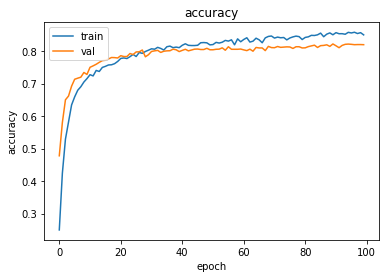

In [31]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.title('accuracy')
plt.show()

### **Loss**

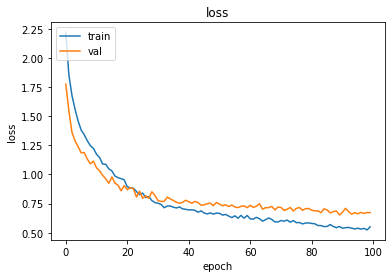

In [32]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.title('loss')
plt.show()

# **Evaluate**

In [33]:
test_data.reset()
predictions = model.predict_generator(test_data, steps=test_data.samples/test_data.batch_size,verbose=1)
y_pred= np.argmax(predictions, axis=1)

1002/1002 [==============================] - 23s 23ms/step


### **Classification Report**

In [34]:
Y_pred = predictions
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
print(confusion_matrix(name_as_indexes_test, y_pred))
print('Classification Report')
classes_names = ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']
print(classification_report(name_as_indexes_test, y_pred, target_names=classes_names))

Confusion Matrix
[[ 12   7   8   0  10   4   0]
 [  2  29   5   0   5   6   0]
 [  0   5  85   0  10  25   0]
 [  0   2   5   4   1   3   0]
 [  2   1  20   0  59  27   1]
 [  0   1  28   1  13 606   0]
 [  0   0   0   0   0   1  14]]
Classification Report
              precision    recall  f1-score   support

       akiec       0.75      0.29      0.42        41
         bcc       0.64      0.62      0.63        47
         bkl       0.56      0.68      0.62       125
          df       0.80      0.27      0.40        15
         mel       0.60      0.54      0.57       110
          nv       0.90      0.93      0.92       649
        vasc       0.93      0.93      0.93        15

    accuracy                           0.81      1002
   macro avg       0.74      0.61      0.64      1002
weighted avg       0.81      0.81      0.80      1002



### **Confusion Matrix**

Confusion matrix, without normalization
[[ 12   7   8   0  10   4   0]
 [  2  29   5   0   5   6   0]
 [  0   5  85   0  10  25   0]
 [  0   2   5   4   1   3   0]
 [  2   1  20   0  59  27   1]
 [  0   1  28   1  13 606   0]
 [  0   0   0   0   0   1  14]]


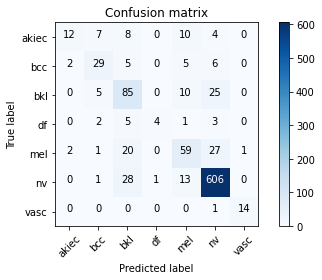

In [35]:
cm = (confusion_matrix(name_as_indexes_test, y_pred))

plot_confusion_matrix(cm, classes_names)

### **Sensitivity & Specificity**

In [0]:
total = sum(sum(cm))
sensitivity = cm[0, 0] / (cm[0, 0] + cm[0, 1])
specificity = cm[1, 1] / (cm[1, 0] + cm[1, 1])

In [37]:
print("sensitivity: {:.4f}".format(sensitivity))
print("specificity: {:.4f}".format(specificity))

sensitivity: 0.6316
specificity: 0.9355


# **Grad-CAM**

In [0]:
last_conv2d = 'conv5_block16_2_conv'

### **AKIEC**

In [0]:
akiec_img = '/content/ham10000-with-one-image-folder/HAM1000_images/ISIC_0026492.jpg'

Model prediction:
	mel            	(4)	with probability 0.976
	akiec          	(0)	with probability 0.010
	df             	(3)	with probability 0.007
	bkl            	(2)	with probability 0.004
	bcc            	(1)	with probability 0.002
Explanation for 'mel'


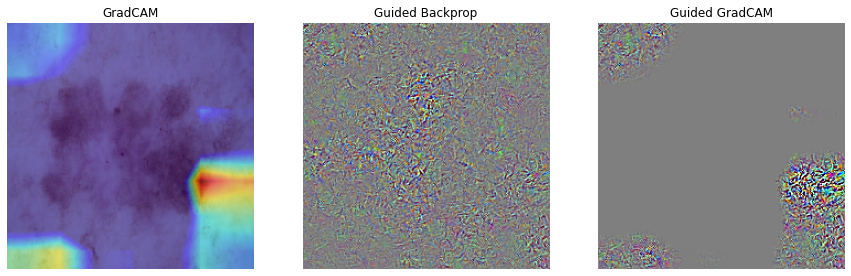

In [40]:
gradcam, gb, guided_gradcam = compute_saliency(model, model, akiec_img, layer_name=last_conv2d)

### **BCC**

In [0]:
bcc_img = '/content/ham10000-with-one-image-folder/HAM1000_images/ISIC_0024332.jpg'

Model prediction:
	nv             	(5)	with probability 0.969
	mel            	(4)	with probability 0.011
	bcc            	(1)	with probability 0.007
	akiec          	(0)	with probability 0.005
	df             	(3)	with probability 0.005
Explanation for 'nv'


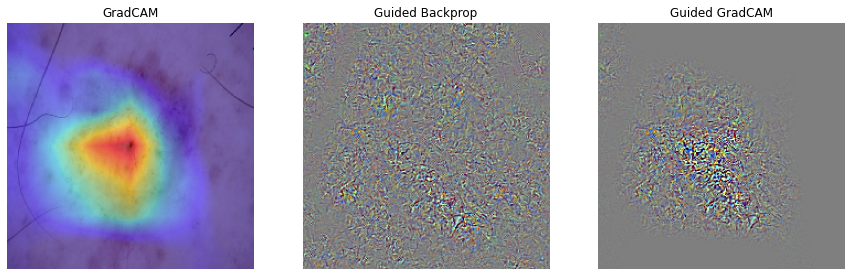

In [42]:
gradcam, gb, guided_gradcam = compute_saliency(model, model, bcc_img, layer_name=last_conv2d)

### **BKL**

In [0]:
bkl_img = '/content/ham10000-with-one-image-folder/HAM1000_images/ISIC_0025548.jpg'

Model prediction:
	mel            	(4)	with probability 0.496
	bkl            	(2)	with probability 0.462
	bcc            	(1)	with probability 0.015
	akiec          	(0)	with probability 0.013
	df             	(3)	with probability 0.009
Explanation for 'mel'


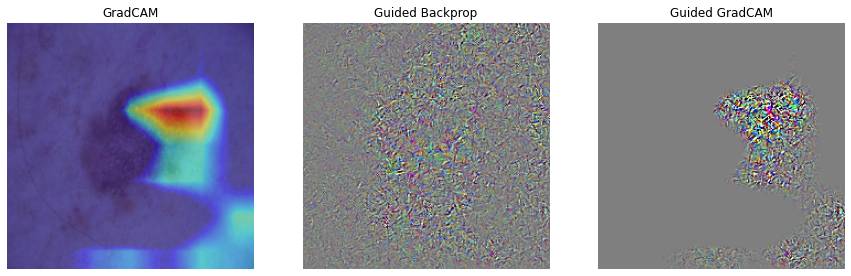

In [44]:
gradcam, gb, guided_gradcam = compute_saliency(model, model, bkl_img, layer_name=last_conv2d)

### **DF**

In [0]:
df_img = '/content/ham10000-with-one-image-folder/HAM1000_images/ISIC_0033626.jpg'

Model prediction:
	df             	(3)	with probability 0.457
	mel            	(4)	with probability 0.319
	bkl            	(2)	with probability 0.196
	nv             	(5)	with probability 0.019
	vasc           	(6)	with probability 0.005
Explanation for 'df'


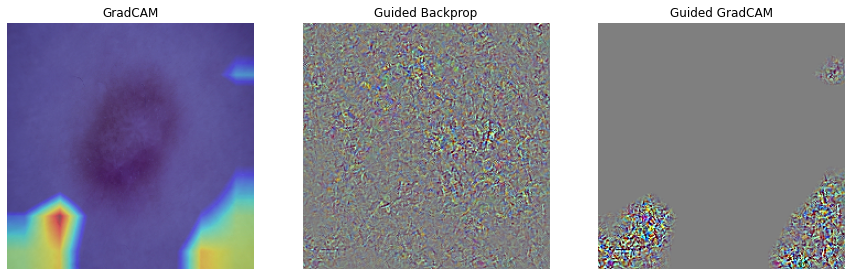

In [46]:
gradcam, gb, guided_gradcam = compute_saliency(model, model, df_img, layer_name=last_conv2d)

### **MEL**

In [0]:
mel_img = '/content/ham10000-with-one-image-folder/HAM1000_images/ISIC_0024516.jpg'

Model prediction:
	mel            	(4)	with probability 0.904
	bkl            	(2)	with probability 0.035
	akiec          	(0)	with probability 0.028
	nv             	(5)	with probability 0.013
	df             	(3)	with probability 0.011
Explanation for 'mel'


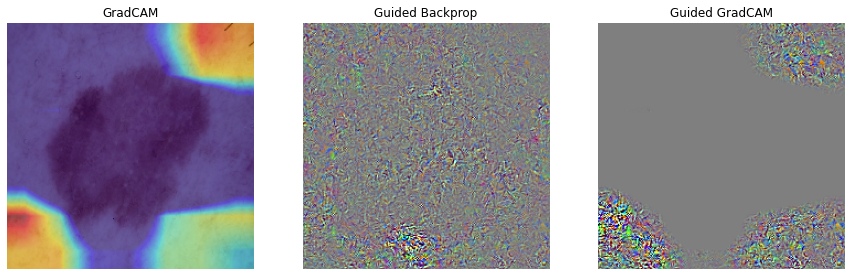

In [48]:
gradcam, gb, guided_gradcam = compute_saliency(model, model, mel_img, layer_name=last_conv2d)

### **NV**

In [0]:
nv_img = '/content/ham10000-with-one-image-folder/HAM1000_images/ISIC_0024349.jpg'

Model prediction:
	nv             	(5)	with probability 0.706
	bkl            	(2)	with probability 0.128
	mel            	(4)	with probability 0.065
	vasc           	(6)	with probability 0.053
	df             	(3)	with probability 0.037
Explanation for 'nv'


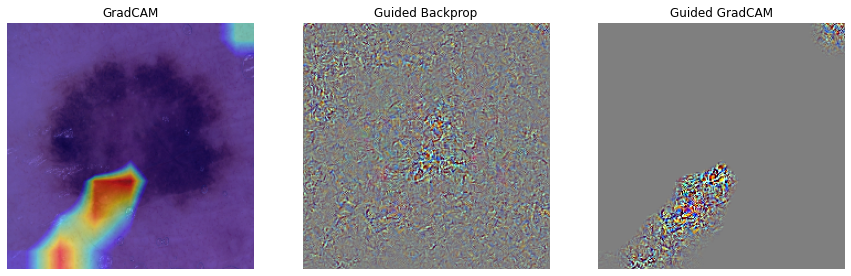

In [50]:
gradcam, gb, guided_gradcam = compute_saliency(model, model, nv_img, layer_name=last_conv2d)

### **VASC**

In [0]:
vasc_img = '/content/ham10000-with-one-image-folder/HAM1000_images/ISIC_0025452.jpg'

Model prediction:
	vasc           	(6)	with probability 0.977
	akiec          	(0)	with probability 0.009
	bkl            	(2)	with probability 0.004
	nv             	(5)	with probability 0.004
	df             	(3)	with probability 0.003
Explanation for 'vasc'


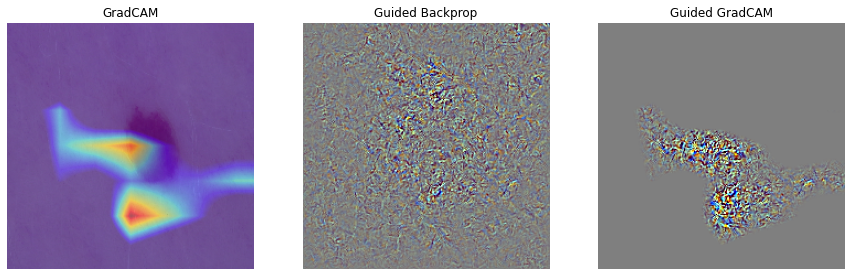

In [52]:
gradcam, gb, guided_gradcam = compute_saliency(model, model, vasc_img, layer_name=last_conv2d)

# **Download Model**

In [0]:
from google.colab import files

In [0]:
files.download('/content/CW_Focal-Loss_ResNet50_model.h5')
files.download('/content/CW_Focal-Loss_ResNet50_weights.h5')